# Multilayer thin film optimization

The language of transfer/scatter matrices is commonly used to calculate optical properties of thin-films. Many specialized methods exist for their optimization. However, SAX can be useful to cut down on developer time by circumventing the need to manually take gradients of complicated or often-changed objective functions, and by generating efficient code from simple syntax. 

## Imports

In [1]:
import tqdm
import matplotlib.pyplot as plt

# Path to GPU
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-10.0
#%env CUDA_DIR=/usr/local/cuda

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt

# sax circuit simulator
import sys
sys.path.append("..")
import sax

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-10.0


In [2]:
from jax.lib import xla_bridge 
print(xla_bridge.get_backend().platform)

gpu


## Dielectric mirror Fabry-Pérot

Consider a stack composed of only two materials, one high index $n_A$ and one low-index $n_B$. Two types of transfer matrices characterize wave propagation in the system : interfaces described by Fresnel's equations, and propagation.

In [3]:
# Reflection at i-->j interface
def r_ij(params):
    """
    Normal incidence amplitude reflection from Fresnel's equations
    ni : refractive index of the initial medium
    nf : refractive index of the final
    """
    return (params["ni"] - params["nj"]) / (params["ni"] + params["nj"])

# Transmission at i-->j interface
def t_ij(params):
    """
    Normal incidence amplitude transmission from Fresnel's equations
    """
    return 2 * params["ni"] / (params["ni"] + params["nj"])

# Propagation through medium A
def prop_i(params):
    """
    Phase shift acquired as a wave propagates through medium A
    wl : wavelength (arb. units)
    ni : refractive index of medium (at wavelength wl)
    di : thickness of layer (same arb. unit as wl)
    """
    return jnp.exp(1j * 2*jnp.pi * params["ni"] / params["wl"] * params["di"])

For the two-material stack, this leads to 4 scatter matrices coefficients. THrough reciprocity they can be constructed out of two independent ones :

In [4]:
# Arbitrary default parameters
interface_ij = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_ji,
    ("out", "out"): lambda params: -1*r_ij(params), # r_ji,
    "default_params": {
        "ni": 1.,
        "nj": 1.,
        "wl": 532.,
    }
}

propagation_i = {
    ("in", "out"): prop_i,
    ("out", "in"): prop_i,
    "default_params": {
        "ni": 1.,
        "di": 500.,
        "wl": 532.,
    }
}

A resonant cavity can be formed when a high index region is surrounded by low-index region :

In [5]:
fabry_perot = sax.circuit(
    models = {
        "air-B": interface_ij,
        "B": propagation_i,
        "B-air": interface_ij,
    },
    connections={
        "air-B:out": "B:in",
        "B:out": "B-air:in",
    },
    ports={
        "air-B:in": "in",
        "B-air:out": "out",
    },
)

params = fabry_perot["default_params"]
params

{'B-air': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'air-B': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'B': {'ni': 1.0, 'di': 500.0, 'wl': 532.0}}

Let's choose $n_A = 1$, $n_B = 2$, $d_B = 1000$ nm, and compute over the visible spectrum :

In [6]:
params = sax.copy_params(params)
params["air-B"]["nj"] = 2.
params["B"]["ni"] = 2.
params["B-air"]["ni"] = 2.
#print(params)
wls = jnp.linspace(380, 750, 200)
params = sax.set_global_params(params, wl=wls)

Compute transmission and reflection, and compare to another package's results (https://github.com/sbyrnes321/tmm) :

In [7]:
fabry_perot_transmitted = fabry_perot["in","out"]
fabry_perot_transmitted = jax.jit(fabry_perot["in", "out"])
transmitted = fabry_perot_transmitted(params)

fabry_perot_reflected = fabry_perot["in","in"]
fabry_perot_reflected = jax.jit(fabry_perot["in", "in"])
reflected = fabry_perot_reflected(params)

In [8]:
# import sys
# !$sys.executable -m pip install tmm
from tmm import coh_tmm

# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf,500,jnp.inf]
n_list = [1,2,1]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
Tnorm = []
Rnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])
    Tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['T'])
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['R'])

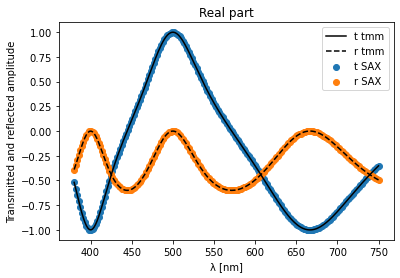

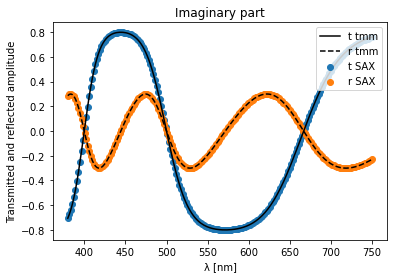

In [9]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

In terms of powers, we get the following. Due to the reflections at the interfaces, resonant behaviour is observed, with evenly-spaced maxima/minima in wavevector space :

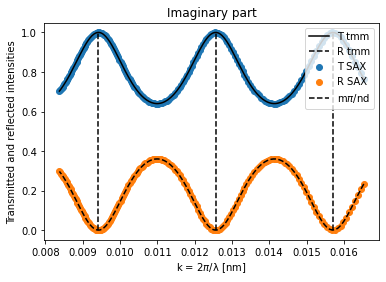

In [22]:
plt.scatter(2*jnp.pi/wls, jnp.abs(transmitted)**2, label='T SAX')
plt.plot(2*jnp.pi/wls, Tnorm, 'k', label='T tmm')
plt.scatter(2*jnp.pi/wls, jnp.abs(reflected)**2, label='R SAX')
plt.plot(2*jnp.pi/wls, Rnorm, 'k--', label='R tmm')
plt.vlines(jnp.arange(3,6)*jnp.pi/(2*500), ymin=0, ymax=1, color='k', linestyle='--', label='m$\pi$/nd')
plt.xlabel("k = 2$\pi$/λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

### Optimization test

Let's attempt to minimize transmission at 500 nm by varying thickness.

In [23]:
@jax.jit
def loss(thickness):
    params = sax.set_global_params(fabry_perot["default_params"], wl=500.)
    params["B"]["di"] = thickness
    params["air-B"]["nj"] = 2.
    params["B"]["ni"] = 2.
    params["B-air"]["ni"] = 2.
    detected = fabry_perot["in", "out"](params)
    return abs(detected)**2

In [24]:
%time loss(500.)

CPU times: user 190 ms, sys: 6.74 ms, total: 196 ms
Wall time: 182 ms


DeviceArray(1.0000002, dtype=float32)

In [25]:
grad = jax.jit(jax.grad(loss))

In [27]:
%time grad(500.)

CPU times: user 296 µs, sys: 1.33 ms, total: 1.62 ms
Wall time: 751 µs


Buffer(-9.887289e-09, dtype=float32)

In [28]:
initial_thickness = 500.
optim_init, optim_update, optim_params = opt.adam(step_size=10)
optim_state = optim_init(initial_thickness)

@jax.jit
def train_step(step, optim_state):
    params = optim_params(optim_state)
    lossvalue = loss(params)
    gradvalue = grad(params)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [29]:
range_ = tqdm.trange(1000)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

100%|██████████| 1000/1000 [00:01<00:00, 682.94it/s, loss=0.640000]


In [30]:
thickness = optim_params(optim_state)
thickness

Buffer(562.5, dtype=float32)

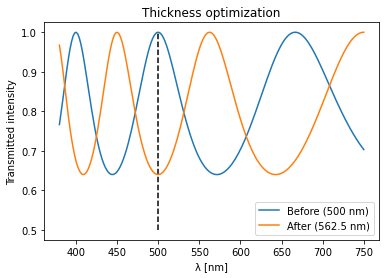

In [31]:
params = sax.set_global_params(fabry_perot["default_params"], wl=wls)
params["B"]["di"] = thickness
params["air-B"]["nj"] = 2.
params["B"]["ni"] = 2.
params["B-air"]["ni"] = 2.
detected = fabry_perot["in", "out"](params)

plt.plot(wls, jnp.abs(transmitted)**2, label='Before (500 nm)')
plt.plot(wls, jnp.abs(detected)**2, label="After ({} nm)".format(thickness))
plt.vlines(500, 0.5, 1, 'k', linestyle='--')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted intensity")
plt.legend(loc="lower right")
plt.title("Thickness optimization")
plt.show()

## General Fabry-Pérot étalon

We reuse the propagation matrix above, and instead of simple interface matrices, model Fabry-Pérot mirrors as general lossless reciprocal scatter matrices :

$$ \left(\begin{array}{c} 
E_t \\
E_r
\end{array}\right) = E_{out} = SE_{in} = \left(\begin{array}{cc} 
t & r \\
r & t
\end{array}\right) \left(\begin{array}{c} 
E_0 \\
0
\end{array}\right) $$

For lossless reciprocal systems, we further have the requirements

$$ |t|^2 + |r|^2 = 1 $$

and

$$ \angle t - \angle r = \pm \pi/2 $$

The general Fabry-Pérot cavity is analytically described by :

In [32]:
# General Fabry-Pérot transfer function (Airy formulas)
def airy_t13(t12, t23, r21, r23, wl, d=1000., n=1.):
    '''
    Assumptions 
    Each mirror lossless, reciprocal : tij = tji, rij = rji
    
    Inputs
    t12 and r12 : S-parameters of the first mirror
    t23 and r23 : S-parameters of the second mirror
    wl : wavelength
    d : gap between the two mirrors (in units of wavelength)
    n : index of the gap between the two mirrors
    
    Returns
    t13 : complex transmission amplitude of the mirror-gap-mirror system
    '''
    # Assume each mirror lossless, reciprocal : tij = tji, rij = rji
    phi = n*2*jnp.pi/wl*d
    return t12*t23*jnp.exp(-1j*phi)/( 1 - r21*r23*jnp.exp(-2j*phi) )

def airy_r13(t12, t23, r21, r23, wl, d=1000., n=1.):
    '''
    Assumptions, inputs : see airy_t13
    
    Returns
    r13 : complex reflection amplitude of the mirror-gap-mirror system
    '''
    phi = n*2*jnp.pi/wl*d
    return r21 + t12*t12*r23*jnp.exp(-2j*phi)/( 1 - r21*r23*jnp.exp(-2j*phi) )

We need to implement the relationship between $t$ and $r$ for lossless reciprocal mirrors. The design parameter will be the amplitude and phase of the tranmission coefficient. The reflection coefficient is then fully determined :

In [33]:
# Obtaining same transfer function from SAX
def t_complex(params):
    # Transmission coefficient (design parameter)
    return params['t_amp']*jnp.exp(-1j*params['t_ang'])

def r_complex(params):
    # Reflection coefficient, derived from transmission coefficient
    # Magnitude from |t|^2 + |r|^2 = 1
    # Phase from phase(t) - phase(r) = pi/2
    r_amp = jnp.sqrt( ( 1. - params['t_amp']**2 ) )
    r_ang = params['t_ang'] - jnp.pi/2
    return r_amp*jnp.exp(-1j*r_ang)

Let's see the expected result for half-mirrors :

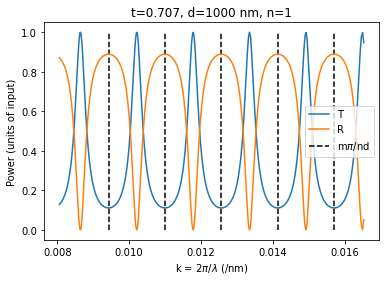

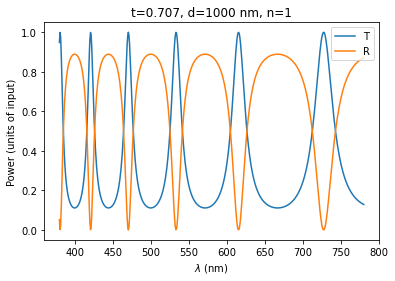

In [34]:
t_initial = jnp.sqrt(0.5)
params_analytical_test = {"t_amp": t_initial, "t_ang": 0.0}
r_initial = r_complex(params_analytical_test)

wls = jnp.linspace(380, 780, 500)

T_analytical_initial = jnp.abs(airy_t13(t_initial, t_initial, r_initial, r_initial, wls, d=2000., n=1.))**2
R_analytical_initial = jnp.abs(airy_r13(t_initial, t_initial, r_initial, r_initial, wls, d=2000., n=1.))**2

plt.title('t=0.707, d=1000 nm, n=1')
plt.plot(2*jnp.pi/wls, T_analytical_initial, label='T')
plt.plot(2*jnp.pi/wls, R_analytical_initial, label='R')
plt.vlines(jnp.arange(6,11)*jnp.pi/2000, ymin=0, ymax=1, color='k', linestyle='--', label='m$\pi$/nd')
plt.xlabel('k = 2$\pi$/$\lambda$ (/nm)')
plt.ylabel('Power (units of input)')
plt.legend()
plt.show()

plt.title('t=0.707, d=1000 nm, n=1')
plt.plot(wls, T_analytical_initial, label='T')
plt.plot(wls, R_analytical_initial, label='R')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Power (units of input)')
plt.legend()

In [35]:
# Is power conserved? (to within 0.1%)
assert jnp.isclose(R_analytical_initial + T_analytical_initial, 1, 0.001).all()

Now let's do the same with SAX by defining new elements :

In [36]:
mirror = {
    ("in", "in"): r_complex,
    ("in", "out"): t_complex,
    ("out", "in"): t_complex, # lambda params: (1 - r_complex(params)**2)/t_complex(params), # t_ji,
    ("out", "out"): r_complex, # lambda params: -1*r_complex(params), # r_ji,
    "default_params": {
        "t_amp": jnp.sqrt(0.5),
        "t_ang": 0.0,
    }
}

fabry_perot_tunable = sax.circuit(
    models = {
        "mirror1": mirror,
        "gap": propagation_i,
        "mirror2": mirror,
    },
    connections={
        "mirror1:out": "gap:in",
        "gap:out": "mirror2:in",
    },
    ports={
        "mirror1:in": "in",
        "mirror2:out": "out",
    },
)

params = fabry_perot_tunable["default_params"]
params = sax.copy_params(params)
params

{'mirror2': {'t_amp': DeviceArray(0.70710677, dtype=float32), 't_ang': 0.0},
 'mirror1': {'t_amp': DeviceArray(0.70710677, dtype=float32), 't_ang': 0.0},
 'gap': {'ni': 1.0, 'di': 500.0, 'wl': 532.0}}

In [37]:
fabry_perot_tunable = sax.circuit(
    models = {
        "mirror1": mirror,
        "gap": propagation_i,
        "mirror2": mirror,
    },
    connections={
        "mirror1:out": "gap:in",
        "gap:out": "mirror2:in",
    },
    ports={
        "mirror1:in": "in",
        "mirror2:out": "out",
    },
)

params = fabry_perot_tunable["default_params"]
params = sax.copy_params(params)
params

{'mirror2': {'t_amp': DeviceArray(0.70710677, dtype=float32), 't_ang': 0.0},
 'mirror1': {'t_amp': DeviceArray(0.70710677, dtype=float32), 't_ang': 0.0},
 'gap': {'ni': 1.0, 'di': 500.0, 'wl': 532.0}}

Since we want wavelength-dependent parameters, we can iterate over models. Just-in-time compilation will unroll the loop and optimize as possible.

In [38]:
N = 100
wls = jnp.linspace(380, 780, N)
params = sax.copy_params(fabry_perot_tunable["default_params"])
params = sax.set_global_params(params, wl=wls)
params = sax.set_global_params(params, t_amp=jnp.sqrt(0.5))
params = sax.set_global_params(params, t_ang=0.0)
params["gap"]["ni"] = 1.
params["gap"]["di"] = 2000.
transmitted_initial = fabry_perot_tunable["in","out"](params)
reflected_initial = fabry_perot_tunable["out","out"](params)

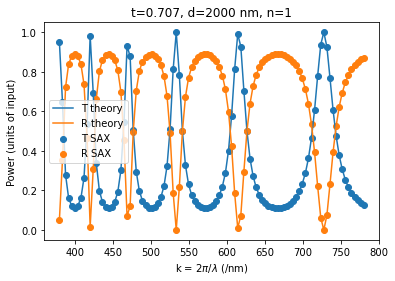

In [39]:
T_analytical_initial = jnp.abs(airy_t13(t_initial, t_initial, r_initial, r_initial, wls, d=2000., n=1.))**2
R_analytical_initial = jnp.abs(airy_r13(t_initial, t_initial, r_initial, r_initial, wls, d=2000., n=1.))**2

plt.title('t=0.707, d=2000 nm, n=1')
plt.plot(wls, T_analytical_initial, label='T theory')
plt.scatter(wls, jnp.abs(transmitted_initial)**2, label='T SAX')
plt.plot(wls, R_analytical_initial, label='R theory')
plt.scatter(wls, jnp.abs(reflected_initial)**2, label='R SAX')
#plt.vlines(jnp.arange(6,11)*jnp.pi/2000, ymin=0, ymax=1, color='k', linestyle='--', label='m$\pi$/nd')
plt.xlabel('k = 2$\pi$/$\lambda$ (/nm)')
plt.ylabel('Power (units of input)')
plt.legend()
plt.show()

Our circuit seems sounds.

# Wavelength-dependent Fabry-Pérot étalon

Let's repeat with a model where parameters can be wavelength-dependent. To comply with the optimizer object, we will stack all design parameters in a single array :

In [40]:
ts_initial = jnp.zeros(2*N)
ts_initial = jax.ops.index_update(ts_initial, jax.ops.index[0:N], jnp.sqrt(0.5))

We will simply loop over all wavelengths, and use different $t$ parameters at each wavelength :

In [41]:
wls = jnp.linspace(380, 780, N)
transmitted = jnp.zeros_like(wls)
reflected = jnp.zeros_like(wls)

for i in range(N):
    # Update parameters
    params = sax.copy_params(fabry_perot_tunable["default_params"])
    params = sax.set_global_params(params, wl=wls[i])
    params = sax.set_global_params(params, t_amp=ts_initial[i])
    params = sax.set_global_params(params, t_ang=ts_initial[N+i])
    params["gap"]["ni"] = 1.
    params["gap"]["di"] = 2000.
    # Perform computation
    transmission_i = fabry_perot_tunable["in","out"](params)
    transmitted = jax.ops.index_update(transmitted, jax.ops.index[i], jnp.abs(transmission_i)**2)
    reflected_i = fabry_perot_tunable["in","in"](params)
    reflected = jax.ops.index_update(reflected, jax.ops.index[i], jnp.abs(reflected_i)**2)

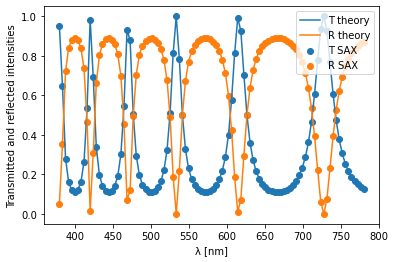

In [42]:
plt.plot(wls, T_analytical_initial, label='T theory')
plt.scatter(wls, transmitted, label='T SAX')
plt.plot(wls, R_analytical_initial, label='R theory')
plt.scatter(wls, reflected, label='R SAX')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.show()

Since it seems to work, let's add a target and optimize some harmonics away :

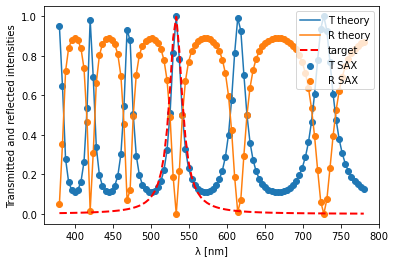

In [47]:
def lorentzian(l0, dl, wl, A):
    return A/((wl - l0)**2 + (0.5*dl)**2)

target = lorentzian(533, 20, wls, 100)

plt.plot(wls, T_analytical_initial, label='T theory')
plt.scatter(wls, transmitted, label='T SAX')
plt.plot(wls, R_analytical_initial, label='R theory')
plt.scatter(wls, reflected, label='R SAX')
plt.plot(wls, target, 'r--', linewidth=2, label='target')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.show()

Defining the loss as the mean squared error between transmission and target transmission :

In [48]:
@jax.jit
def loss(ts):

    N = len(ts[::2])
    wls = jnp.linspace(380, 780, N)
    transmitted = jnp.zeros_like(wls)
    target = lorentzian(533, 20, wls, 100)
    
    for i in range(N):
        # Update parameters
        params = sax.copy_params(fabry_perot_tunable["default_params"])
        params = sax.set_global_params(params, wl=wls[i])
        params = sax.set_global_params(params, t_amp=ts[i])
        params = sax.set_global_params(params, t_ang=ts[N+i])
        params["gap"]["ni"] = 1.
        params["gap"]["di"] = 1000.
        # Perform computation
        transmission_i = fabry_perot_tunable["in","out"](params)
        transmitted = jax.ops.index_update(transmitted, jax.ops.index[i], jnp.abs(transmission_i)**2)
        
    return (jnp.abs(transmitted - target)**2).mean()

In [49]:
grad = jax.jit(jax.grad(loss))

In [50]:
optim_init, optim_update, optim_params = opt.adam(step_size=0.001)

@jax.jit
def train_step(step, optim_state):
    params = optim_params(optim_state)
    lossvalue = loss(params)
    gradvalue = grad(params)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [51]:
range_ = tqdm.trange(2000)

optim_state = optim_init(ts_initial)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

100%|██████████| 2000/2000 [00:49<00:00, 40.34it/s, loss=0.000061] 


In [52]:
ts_optimal = optim_params(optim_state)

In [57]:
wls = jnp.linspace(380, 780, N)
transmitted_optimal = jnp.zeros_like(wls)
reflected_optimal = jnp.zeros_like(wls)

for i in range(N):
    # Update parameters
    params = sax.copy_params(fabry_perot_tunable["default_params"])
    params = sax.set_global_params(params, wl=wls[i])
    params = sax.set_global_params(params, t_amp=ts_optimal[i])
    params = sax.set_global_params(params, t_ang=ts_optimal[N+i])
    params["gap"]["ni"] = 1.
    params["gap"]["di"] = 1000.
    # Perform computation
    transmission_i = fabry_perot_tunable["in","out"](params)
    transmitted_optimal = jax.ops.index_update(transmitted_optimal, jax.ops.index[i], jnp.abs(transmission_i)**2)
    reflected_i = fabry_perot_tunable["in","in"](params)
    reflected_optimal = jax.ops.index_update(reflected_optimal, jax.ops.index[i], jnp.abs(reflected_i)**2)

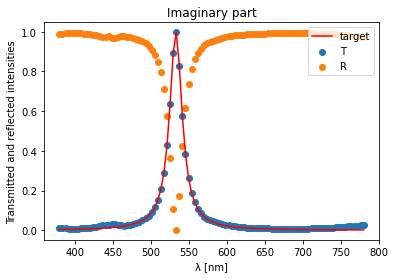

In [61]:
plt.scatter(wls, transmitted_optimal, label='T')
plt.scatter(wls, reflected_optimal, label='R')
plt.plot(wls, lorentzian(533, 20, wls, 100), 'r', label='target')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

The hard part is now to find physical stacks that physically implement $t(\lambda)$. However, the ease with which we can modify and complexify the loss function opens opportunities for regularization and complicated objective functions.